---

[INFO] Downloading and streaming PGN ZST...
[INFO] Collected total=20250 games
[INFO] Collected total=40500 games
[INFO] Collected total=60750 games
[INFO] Collected total=81000 games
[INFO] Collected total=101250 games
[INFO] Collected total=121500 games
[INFO] Collected total=141750 games
[INFO] Collected total=162000 games
[INFO] Collected total=182250 games
[INFO] Collected total=202500 games
[INFO] Finished extraction. Total games collected: 202509
[INFO] Dataset saved as lichess_2025_games_with_moves.csv


C:\Users\joshu\AppData\Local\Temp\ipykernel_16152\913214929.py:123: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_df = df.groupby('diff_bin')['lower_result'].value_counts(normalize=True).unstack().fillna(0)



Probabilities of lower-rated player outcomes by rating difference:
lower_result   diff_bin       win      draw      loss
0                 0-100  0.454725  0.036153  0.509121
1               101-200  0.345390  0.041400  0.613210
2               201-300  0.260286  0.035864  0.703850
3               301-400  0.203611  0.026124  0.770265
4               401-500  0.157030  0.023737  0.819233
5               501-600  0.114930  0.016112  0.868958
6               601-700  0.110915  0.015845  0.873239
7               701-800  0.093656  0.015106  0.891239
8               801-900  0.066327  0.005102  0.928571
9              901-1000  0.116667  0.008333  0.875000
10            1001-1100  0.108434  0.000000  0.891566
11            1101-1200  0.081633  0.020408  0.897959


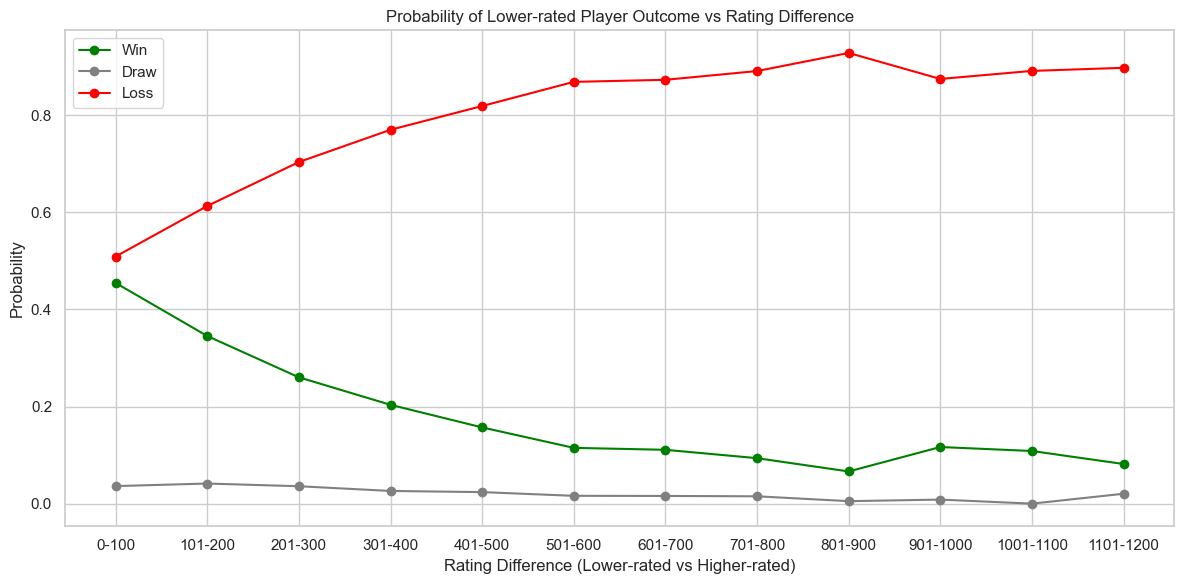

[INFO] Probabilities by rating difference saved as lower_player_probabilities.csv


In [11]:

import requests
import zstandard as zstd
import chess.pgn
import io
from io import TextIOWrapper
import pandas as pd
import sys
import subprocess
import importlib
import chess.pgn
from io import StringIO
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# ---------------- PARAMETERS ----------------
ZST_URL = "https://database.lichess.org/standard/lichess_db_standard_rated_2025-09.pgn.zst"
N_GAMES = 202509
PROGRESS_INTERVAL = N_GAMES // 10
OUTPUT_CSV = "lichess_2025_games_with_moves.csv"

# ---------------- STREAM AND EXTRACT ----------------
def stream_lichess_subset(url, n_games=N_GAMES):
    games_data = []
    collected = 0
    print("[INFO] Downloading and streaming PGN ZST...")

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(r.raw) as reader:
            text_stream = TextIOWrapper(reader, encoding='utf-8', errors='ignore')

            while collected < n_games:
                game = chess.pgn.read_game(text_stream)
                if game is None:
                    break

                headers = {k: game.headers.get(k, "") for k in game.headers}
                result = headers.get("Result", "")
                white_elo = headers.get("WhiteElo", "0")
                black_elo = headers.get("BlackElo", "0")

                try:
                    white_elo = int(white_elo)
                except ValueError:
                    white_elo = 0
                try:
                    black_elo = int(black_elo)
                except ValueError:
                    black_elo = 0

                # Convert the whole game to text (includes moves and result)
                game_text = str(game)

                # Skip empty or corrupt games
                if len(game_text.strip()) < 40:
                    continue

                game_row = {
                    "white": headers.get("White", ""),
                    "black": headers.get("Black", ""),
                    "white_rating": white_elo,
                    "black_rating": black_elo,
                    "result": result,
                    "pgn": game_text
                }

                games_data.append(game_row)
                collected += 1

                if collected % PROGRESS_INTERVAL == 0:
                    print(f"[INFO] Collected total={collected} games")

    print(f"[INFO] Finished extraction. Total games collected: {len(games_data)}")
    return pd.DataFrame(games_data)

# ---------------- RUN PIPELINE ----------------
if __name__ == "__main__":
    df_final = stream_lichess_subset(ZST_URL, N_GAMES)
    df_final.to_csv(OUTPUT_CSV, index=False)
    print(f"[INFO] Dataset saved as {OUTPUT_CSV}")

DATA_PATH = "lichess_2025_games_with_moves.csv"  # update to  CSV path
df = pd.read_csv(DATA_PATH)

# Keep necessary columns
df = df[['white_rating', 'black_rating', 'result']].dropna()

# -------------------- Step 2: Define Rating Difference --------------------
# Lower-rated player is always the one considered
df['rating_diff'] = df['white_rating'] - df['black_rating']
# Identify lower-rated player result
def lower_player_result(row):
    if row['rating_diff'] >= 0:  # White higher-rated
        if row['result'] == '1-0':
            return 'loss'  # lower player (Black) lost
        elif row['result'] == '0-1':
            return 'win'   # lower player (Black) won
        else:
            return 'draw'
    else:  # Black higher-rated
        if row['result'] == '1-0':
            return 'win'   # lower player (White) won
        elif row['result'] == '0-1':
            return 'loss'  # lower player (White) lost
        else:
            return 'draw'

df['lower_result'] = df.apply(lower_player_result, axis=1)

# Absolute rating difference
df['abs_diff'] = abs(df['rating_diff'])

# -------------------- Step 3: Define bins --------------------
bins = [0,100,200,300,400,500,600,700,800,900,1000,1100,1200]
labels = ['0-100','101-200','201-300','301-400','401-500','501-600','601-700','701-800','801-900','901-1000','1001-1100','1101-1200']
df['diff_bin'] = pd.cut(df['abs_diff'], bins=bins, labels=labels, right=False)

# -------------------- Step 4: Compute probabilities --------------------
prob_df = df.groupby('diff_bin')['lower_result'].value_counts(normalize=True).unstack().fillna(0)
prob_df = prob_df[['win','draw','loss']]  # ensure order
prob_df = prob_df.reset_index()

print("\nProbabilities of lower-rated player outcomes by rating difference:")
print(prob_df)

# -------------------- Step 5: Visualization --------------------
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")
plt.figure(figsize=(12,6))
plt.plot(prob_df['diff_bin'], prob_df['win'], label='Win', marker='o', color='green')
plt.plot(prob_df['diff_bin'], prob_df['draw'], label='Draw', marker='o', color='gray')
plt.plot(prob_df['diff_bin'], prob_df['loss'], label='Loss', marker='o', color='red')
plt.xlabel("Rating Difference (Lower-rated vs Higher-rated)")
plt.ylabel("Probability")
plt.title("Probability of Lower-rated Player Outcome vs Rating Difference")
plt.legend()
plt.tight_layout()
plt.show()

# -------------------- Step 6: Save results --------------------
prob_df.to_csv("lower_player_probabilities.csv", index=False)
print("[INFO] Probabilities by rating difference saved as lower_player_probabilities.csv")





---

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [2]:
import os
import json
import subprocess
from IPython.display import display, Javascript
import ipynbname

# 1. Save the notebook
display(Javascript('IPython.notebook.save_checkpoint();'))

# 2. Detect current notebook filename
nb_path = ipynbname.path()
notebook_name = str(nb_path.name)

# 3. Load notebook JSON
with open(notebook_name, "r", encoding="utf-8") as f:
    data = json.load(f)

# 4. Force a dummy change to ensure Git detects a difference
# Adds a harmless comment to the first code cell
if "cells" in data and len(data["cells"]) > 0:
    first_cell = data["cells"][0]
    if first_cell.get("cell_type") == "code":
        # Remove any previous dummy line to keep notebook clean
        first_cell["source"] = [line for line in first_cell["source"] if "# Auto-update: forced change" not in line]
        first_cell["source"].append("\n# Auto-update: forced change to trigger Git commit\n")

# 5. Rewrite notebook JSON
with open(notebook_name, "w", encoding="utf-8") as f:
    json.dump(data, f, ensure_ascii=False, indent=1)

# 6. Stage for Git
subprocess.run(["git", "add", "-f", notebook_name], check=True)

# 7. Commit changes
try:
    subprocess.run(["git", "commit", "-m", f"Auto-update {notebook_name}"], check=True)
    print(f"Committed changes to {notebook_name}.")
except subprocess.CalledProcessError:
    print("No changes detected by Git. Nothing to commit.")

# 8. Push to GitHub
subprocess.run(["git", "push", "origin", "main"], check=True)
print("Pushed to GitHub successfully.")




<IPython.core.display.Javascript object>

Committed changes to Notebook_Template.ipynb.


CalledProcessError: Command '['git', 'push', 'origin', 'main']' returned non-zero exit status 1.